Nama Anggota:
1. Muhammad Hisyam Kamil - 202210370311060
2. ELGA PUTRI TRI FARMA - 202210370311449

# Membangun Case Base

## Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Download Library

In [ ]:
!pip install pandas requests beautifulsoup4 pdfminer.six lxml lock> /dev/null 2>&1

In [ ]:
import argparse
import io
import os
import re
import time
import urllib
from concurrent.futures import ThreadPoolExecutor, wait
from datetime import date
import pandas as pd
import requests
from bs4 import BeautifulSoup
from pdfminer.high_level import extract_text

## Pemrosesan Scraping Dari Putusan Hakim Medan (Pencurian)

In [ ]:
processed_cases_count = 0
from threading import Lock
lock = Lock()
MAX_FILES_TO_SCRAPE = 50

def create_path(folder_name):
    path = os.path.join(os.getcwd(), folder_name)
    if not os.path.exists(path):
        os.makedirs(path)
    return path

def open_page(link):
    count = 0
    while count < 3:
        try:
            return BeautifulSoup(requests.get(link).text, "lxml")
        except:
            count += 1
            time.sleep(5)

def get_detail(soup, keyword):
    try:
        text = (
            soup.find(lambda tag: tag.name == "td" and keyword in tag.text)
            .find_next()
            .get_text()
            .strip()
        )
        return text
    except:
        return ""

def get_pdf(url, path_pdf, case_number):
    try:
        file = urllib.request.urlopen(url)
        file_extension = os.path.splitext(url)[1]
        file_name = f"case_{case_number:03d}{file_extension}"
        file_content = file.read()
        full_path = os.path.join(path_pdf, file_name)
        with open(full_path, "wb") as out_file:
            out_file.write(file_content)
        return io.BytesIO(file_content), file_name, full_path
    except Exception as e:
        print(f"Error downloading PDF from {url}: {e}")
        return None, None, None

def clean_text(text):
    text = text.replace("M a h ka m a h A g u n g R e p u blik In d o n esia\n", "")
    text = text.replace("Disclaimer\n", "")
    text = text.replace(
        "Kepaniteraan Mahkamah Agung Republik Indonesia berusaha untuk selalu mencantumkan informasi paling kini dan akurat sebagai bentuk komitmen Mahkamah Agung untuk pelayanan publik, transparansi dan akuntabilitas\n",
        "",
    )
    text = text.replace(
        "pelaksanaan fungsi peradilan. Namun dalam hal-hal tertentu masih dimungkinkan terjadi permasalahan teknis terkait dengan akurasi dan keterkinian informasi yang kami sajikan, hal mana akan terus kami perbaiki dari waktu kewaktu.\n",
        "",
    )
    text = text.replace(
        "Dalam hal Anda menemukan inakurasi informasi yang termuat pada situs ini atau informasi yang seharusnya ada, namun belum tersedia, maka harap segera hubungi Kepaniteraan Mahkamah Agung RI melalui :\n",
        "",
    )
    text = text.replace(
        "Email : kepaniteraan@mahkamahagung.go.id    Telp : 021-384 3348 (ext.318)\n",
        "",
    )
    return text

def extract_data(link, keyword_url, path_output_csv, path_output_txt, path_pdf, today, case_counter):
    soup = open_page(link)
    if not soup:
        print(f"Could not open page {link}, skipping case {case_counter}")
        return
    table = soup.find("table", {"class": "table"})
    judul = table.find("h2").text if table.find("h2") else ""

    nomor = get_detail(table, "Nomor")
    tingkat_proses = get_detail(table, "Tingkat Proses")
    klasifikasi = get_detail(table, "Klasifikasi")
    kata_kunci = get_detail(table, "Kata Kunci")
    tahun = get_detail(table, "Tahun")
    tanggal_register = get_detail(table, "Tanggal Register")
    lembaga_peradilan = get_detail(table, "Lembaga Peradilan")
    jenis_lembaga_peradilan = get_detail(table, "Jenis Lembaga Peradilan")
    hakim_ketua = get_detail(table, "Hakim Ketua")
    hakim_anggota = get_detail(table, "Hakim Anggota")
    panitera = get_detail(table, "Panitera")
    amar = get_detail(table, "Amar")
    amar_lainnya = get_detail(table, "Amar Lainnya")
    catatan_amar = get_detail(table, "Catatan Amar")
    tanggal_musyawarah = get_detail(table, "Tanggal Musyawarah")
    tanggal_dibacakan = get_detail(table, "Tanggal Dibacakan")
    kaidah = get_detail(table, "Kaidah")
    status = get_detail(table, "Status")
    abstrak = get_detail(table, "Abstrak")

    label_klasifikasi = "Perdata" if "perdata" in klasifikasi.lower() else "Pidana"

    text_pdf = ""
    file_name_pdf = ""
    link_pdf = ""
    pdf_saved_path = ""

    try:
        link_pdf_tag = soup.find("a", href=re.compile(r"/pdf/"))
        if link_pdf_tag:
            link_pdf = link_pdf_tag["href"]
            file_pdf_io, file_name_pdf, pdf_saved_path = get_pdf(link_pdf, path_pdf, case_counter)
            if file_pdf_io:
                text_pdf = extract_text(file_pdf_io)
                text_pdf = clean_text(text_pdf)
    except Exception as e:
        print(f"Error extracting PDF text for link {link_pdf}: {e}")
        link_pdf = ""
        text_pdf = ""
        file_name_pdf = ""
        pdf_saved_path = ""

    if text_pdf:
        txt_filename = f"case_{case_counter:03d}.txt"
        txt_full_path = os.path.join(path_output_txt, txt_filename)
        try:
            with open(txt_full_path, "w", encoding="utf-8") as txt_file:
                txt_file.write(text_pdf)
            print(f"Saved raw text to: {txt_full_path}")
        except Exception as e:
            print(f"Error saving raw text to {txt_full_path}: {e}")

    data = [
        judul,
        nomor,
        tingkat_proses,
        klasifikasi,
        kata_kunci,
        tahun,
        tanggal_register,
        lembaga_peradilan,
        jenis_lembaga_peradilan,
        hakim_ketua,
        hakim_anggota,
        panitera,
        amar,
        amar_lainnya,
        catatan_amar,
        tanggal_musyawarah,
        tanggal_dibacakan,
        kaidah,
        status,
        abstrak,
        link,
        link_pdf,
        file_name_pdf,
        text_pdf,
        pdf_saved_path,
        label_klasifikasi
    ]
    result = pd.DataFrame(
        [data],
        columns=[
            "judul",
            "nomor",
            "tingkat_proses",
            "klasifikasi",
            "kata_kunci",
            "tahun",
            "tanggal_register",
            "lembaga_peradilan",
            "jenis_lembaga_peradilan",
            "hakim_ketua",
            "hakim_anggota",
            "panitera",
            "amar",
            "amar_lainnya",
            "catatan_amar",
            "tanggal_musyawarah",
            "tanggal_dibacakan",
            "kaidah",
            "status",
            "abstrak",
            "link",
            "link_pdf",
            "file_name_pdf",
            "text_pdf",
            "pdf_saved_path",
            "label_klasifikasi"
        ],
    )

    keyword_url_clean = keyword_url.replace("/", "_").replace(":", "_").replace("?", "_").replace("=", "_").replace("&", "_")
    if keyword_url_clean.startswith("https"):
        keyword_url_clean = "url_scrape"
    destination = f"{path_output_csv}/putusan_ma_{keyword_url_clean}_{today}.csv"

    result.to_csv(destination, mode='a', header=not os.path.exists(destination), index=False)
    print(f"Appended data for case {case_counter} to CSV: {destination}")

def run_process(keyword_url, page, sort_date, path_output_csv, path_output_txt, path_pdf, today):
    global processed_cases_count, lock, MAX_FILES_TO_SCRAPE

    if keyword_url.startswith("https"):
        link = f"{keyword_url}&page={page}"
    else:
        link = f"https://putusan3.mahkamahagung.go.id/search.html?q={keyword_url}&page={page}"
    if sort_date:
        link = f"{link}&obf=TANGGAL_PUTUS&obm=desc"

    soup = open_page(link)
    if not soup:
        print(f"Could not open page list {link}, skipping page.")
        return
    links = soup.find_all("a", {"href": re.compile("/direktori/putusan")})

    for link_tag in links:
        with lock:
            if processed_cases_count >= MAX_FILES_TO_SCRAPE:
                break
            processed_cases_count += 1
            current_case_number = processed_cases_count

        print(f"--- Processing case number: {current_case_number}/{MAX_FILES_TO_SCRAPE} ---")
        extract_data(link_tag["href"], keyword_url, path_output_csv, path_output_txt, path_pdf, today, current_case_number)

def run_scraper(keyword=None, url=None, sort_date=True, download_pdf=True):
    if not keyword and not url:
        print("Please provide a keyword or URL")
        return

    base_drive_path = '/content/drive/MyDrive/Penalaran'
    path_output_csv = os.path.join(base_drive_path, 'CSV')
    path_output_txt = os.path.join(base_drive_path, 'RAW_TEXT')
    path_pdf = os.path.join(base_drive_path, 'PDF')

    os.makedirs(path_output_csv, exist_ok=True)
    os.makedirs(path_output_txt, exist_ok=True)
    os.makedirs(path_pdf, exist_ok=True)

    today = date.today().strftime("%Y-%m-%d")

    link = f"https://putusan3.mahkamahagung.go.id/search.html?q={keyword}&page=1"
    if url:
        link = url

    soup = open_page(link)
    if not soup:
        print(f"Failed to open initial page: {link}. Aborting.")
        return
    pagination_links = soup.find_all("a", {"class": "page-link"})
    if not pagination_links:
        print("No results found for the given keyword or URL.")
        return

    last_page = int(pagination_links[-1].get("data-ci-pagination-page"))

    if url:
        print(f"Scraping with url: {url} - approx {20 * last_page} data - {last_page} page")
        keyword_url = url
    else:
        print(f"Scraping with keyword: {keyword} - approx {20 * last_page} data - {last_page} page")
        keyword_url = keyword

    print(f"Scraping will stop after reaching {MAX_FILES_TO_SCRAPE} files.")

    futures = []

    with ThreadPoolExecutor(max_workers=4) as executor:
        for page in range(last_page):
            with lock:
                if processed_cases_count >= MAX_FILES_TO_SCRAPE:
                    print("Maximum file limit reached. No more pages will be submitted.")
                    break

            futures.append(
                executor.submit(run_process, keyword_url, page + 1, sort_date, path_output_csv, path_output_txt, path_pdf, today)
            )
    wait(futures)
    print(f"\n--- Scraping finished. Total files processed: {processed_cases_count} ---")


## Mendownload 100 file (PDF, TXT) dan raw CSV

In [ ]:
run_scraper(url="https://putusan3.mahkamahagung.go.id/search.html?q=&jenis_doc=putusan&cat=c55a90e6a573d9dc53d89d3aee624816&jd=&tp=&court=8bb6198cd9528aaac4199a1d5627bbb9&t_put=&t_reg=&t_upl=2023&t_pr=")

Scraping with url: https://putusan3.mahkamahagung.go.id/search.html?q=&jenis_doc=putusan&cat=c55a90e6a573d9dc53d89d3aee624816&jd=&tp=&court=8bb6198cd9528aaac4199a1d5627bbb9&t_put=&t_reg=&t_upl=2023&t_pr= - approx 40 data - 2 page
Scraping will stop after reaching 50 files.
--- Processing case number: 1/50 ---
--- Processing case number: 2/50 ---
Appended data for case 2 to CSV: /content/drive/MyDrive/Penalaran/CSV/putusan_ma_url_scrape_2025-06-28.csv
--- Processing case number: 3/50 ---
Saved raw text to: /content/drive/MyDrive/Penalaran/RAW_TEXT/case_001.txt
Appended data for case 1 to CSV: /content/drive/MyDrive/Penalaran/CSV/putusan_ma_url_scrape_2025-06-28.csv
--- Processing case number: 4/50 ---
Appended data for case 4 to CSV: /content/drive/MyDrive/Penalaran/CSV/putusan_ma_url_scrape_2025-06-28.csv
--- Processing case number: 5/50 ---
Appended data for case 5 to CSV: /content/drive/MyDrive/Penalaran/CSV/putusan_ma_url_scrape_2025-06-28.csv
--- Processing case number: 6/50 ---
Ap

# Case Representation

## Fungsi Raw CSV menjadi Processed CSV

In [10]:
import glob

def find_latest_csv(folder_path):
    search_pattern = os.path.join(folder_path, '*.csv')
    csv_files = glob.glob(search_pattern)

    if not csv_files:
        print(f"Error: Tidak ada file CSV yang ditemukan di folder '{folder_path}'")
        return None

    latest_file = max(csv_files, key=os.path.getmtime)
    print(f"File CSV terbaru yang akan diproses: {os.path.basename(latest_file)}")
    return latest_file

def extract_pihak(judul_text):
    if not isinstance(judul_text, str):
        return "Tidak Diketahui"

    judul_lower = judul_text.lower()

    pemisah = None
    if 'melawan' in judul_lower:
        pemisah = 'melawan'
    elif 'lawan' in judul_lower:
        pemisah = 'lawan'
    elif ' vs ' in judul_lower:
        pemisah = ' vs '

    if pemisah:
        try:
            parts = re.split(pemisah, judul_text, maxsplit=1, flags=re.IGNORECASE)
            pihak1_raw = parts[0]
            if 'antara' in pihak1_raw.lower():
                pihak1 = re.split('antara', pihak1_raw, maxsplit=1, flags=re.IGNORECASE)[1].strip()
            else:
                pihak1 = pihak1_raw.split(',')[-1].strip()
            pihak2 = parts[1].strip()
            return f"{pihak1} vs. {pihak2}"
        except Exception:
            return "Gagal Ekstrak"

    return "Tidak Ditemukan Pemisah Pihak"

def create_summary(text, max_words=250):
    if not isinstance(text, str) or not text.strip():
        return "Teks tidak tersedia."

    words = text.split()
    summary_words = words[:max_words]
    summary = ' '.join(summary_words)

    if len(words) > max_words:
        summary += "..."

    return summary

print("Fungsi 'find_latest_csv', 'extract_pihak', dan 'create_summary' telah didefinisikan.")


Fungsi 'find_latest_csv', 'extract_pihak', dan 'create_summary' telah didefinisikan.


## Augmentasi Data

In [11]:
base_drive_path = '/content/drive/MyDrive/Penalaran'
csv_input_path = os.path.join(base_drive_path, 'CSV')
processed_output_path = os.path.join(base_drive_path, 'Processed')

os.makedirs(processed_output_path, exist_ok=True)
print(f"Folder input: {csv_input_path}")
print(f"Folder output: {processed_output_path}")

latest_csv_file = find_latest_csv(csv_input_path)

if latest_csv_file:
    df_raw = pd.read_csv(latest_csv_file)
    print(f"\nBerhasil membaca {len(df_raw)} baris data.")
    print(f"Jumlah kolom asli: {len(df_raw.columns)}")

    df_processed = df_raw.copy()

    print("\nMemulai proses penambahan kolom baru...")

    df_processed.insert(0, 'case_id', range(1, len(df_processed) + 1))
    print(" - Kolom 'case_id' ditambahkan.")

    df_processed['pihak'] = df_processed['judul'].apply(extract_pihak)
    print(" - Kolom 'pihak' ditambahkan.")

    df_processed['ringkasan_fakta'] = df_processed['text_pdf'].apply(create_summary)
    print(" - Kolom 'ringkasan_fakta' ditambahkan.")

    print("\nProses penambahan kolom selesai.")
    print(f"Jumlah kolom sekarang: {len(df_processed.columns)}")

    output_filename = os.path.join(processed_output_path, 'processed_cases.csv')
    df_processed.to_csv(output_filename, index=False)

    print(f"\n[SUCCESS] Data yang telah di-augmentasi berhasil disimpan di:\n{output_filename}")

    print("\nBerikut adalah 5 baris pertama dari data yang sudah diproses (kolom asli + kolom baru):")
    display(df_processed[['case_id', 'nomor', 'pihak', 'ringkasan_fakta']].head())

else:
    print("\nProses dihentikan karena tidak ada file input yang bisa diolah.")


Folder input: /content/drive/MyDrive/Penalaran/CSV
Folder output: /content/drive/MyDrive/Penalaran/Processed
File CSV terbaru yang akan diproses: putusan_ma_url_scrape_2025-06-28.csv

Berhasil membaca 46 baris data.
Jumlah kolom asli: 26

Memulai proses penambahan kolom baru...
 - Kolom 'case_id' ditambahkan.
 - Kolom 'pihak' ditambahkan.
 - Kolom 'ringkasan_fakta' ditambahkan.

Proses penambahan kolom selesai.
Jumlah kolom sekarang: 29

[SUCCESS] Data yang telah di-augmentasi berhasil disimpan di:
/content/drive/MyDrive/Penalaran/Processed/processed_cases.csv

Berikut adalah 5 baris pertama dari data yang sudah diproses (kolom asli + kolom baru):


,case_id,nomor,pihak,ringkasan_fakta
0,1,Putusan MAHKAMAH AGUNG Nomor 7335 K/Pid.Sus/20...,Tidak Ditemukan Pemisah Pihak,Teks tidak tersedia.
1,2,Putusan MAHKAMAH AGUNG Nomor 5005 K/PID.SUS/20...,Tidak Ditemukan Pemisah Pihak,Direktori Putusan Mahkamah Agung Republik Indo...
2,3,Putusan MAHKAMAH AGUNG Nomor 1095 K/Pid/2023 T...,Tidak Ditemukan Pemisah Pihak,Teks tidak tersedia.
3,4,Putusan MAHKAMAH AGUNG Nomor 4291 K/Pid.Sus/20...,Tidak Ditemukan Pemisah Pihak,Teks tidak tersedia.
4,5,Putusan MAHKAMAH AGUNG Nomor 1013 K/Pid/2023 T...,Tidak Ditemukan Pemisah Pihak,Teks tidak tersedia.


## Verifikasi Hasil CSV

In [12]:
output_file_to_check = '/content/drive/MyDrive/Penalaran/Processed/processed_cases.csv'

try:
    print(f"Membaca file hasil proses dari: {output_file_to_check}")
    df_final = pd.read_csv(output_file_to_check)

    print("\nJumlah kolom di file hasil akhir:", len(df_final.columns))
    print("Nama kolom:", df_final.columns.tolist())

    print("\nMenampilkan 5 baris teratas dari file hasil akhir (beberapa kolom kunci):")
    display(df_final[['case_id', 'nomor', 'pihak', 'ringkasan_fakta', 'label_klasifikasi']].head())

except FileNotFoundError:
    print(f"Error: File '{output_file_to_check}' tidak ditemukan. Pastikan Section 3 berjalan tanpa error.")

Membaca file hasil proses dari: /content/drive/MyDrive/Penalaran/Processed/processed_cases.csv

Jumlah kolom di file hasil akhir: 29
Nama kolom: ['case_id', 'judul', 'nomor', 'tingkat_proses', 'klasifikasi', 'kata_kunci', 'tahun', 'tanggal_register', 'lembaga_peradilan', 'jenis_lembaga_peradilan', 'hakim_ketua', 'hakim_anggota', 'panitera', 'amar', 'amar_lainnya', 'catatan_amar', 'tanggal_musyawarah', 'tanggal_dibacakan', 'kaidah', 'status', 'abstrak', 'link', 'link_pdf', 'file_name_pdf', 'text_pdf', 'pdf_saved_path', 'label_klasifikasi', 'pihak', 'ringkasan_fakta']

Menampilkan 5 baris teratas dari file hasil akhir (beberapa kolom kunci):


,case_id,nomor,pihak,ringkasan_fakta,label_klasifikasi
0,1,Putusan MAHKAMAH AGUNG Nomor 7335 K/Pid.Sus/20...,Tidak Ditemukan Pemisah Pihak,Teks tidak tersedia.,Pidana
1,2,Putusan MAHKAMAH AGUNG Nomor 5005 K/PID.SUS/20...,Tidak Ditemukan Pemisah Pihak,Direktori Putusan Mahkamah Agung Republik Indo...,Pidana
2,3,Putusan MAHKAMAH AGUNG Nomor 1095 K/Pid/2023 T...,Tidak Ditemukan Pemisah Pihak,Teks tidak tersedia.,Pidana
3,4,Putusan MAHKAMAH AGUNG Nomor 4291 K/Pid.Sus/20...,Tidak Ditemukan Pemisah Pihak,Teks tidak tersedia.,Pidana
4,5,Putusan MAHKAMAH AGUNG Nomor 1013 K/Pid/2023 T...,Tidak Ditemukan Pemisah Pihak,Teks tidak tersedia.,Pidana


## Membaca Kembali Isi Yang Diproses

In [13]:
import pandas as pd
import os
import re

processed_file_path = '/content/drive/MyDrive/Penalaran/Processed/processed_cases.csv'

try:
    # Kita akan bekerja dengan DataFrame bernama df_final
    df_final = pd.read_csv(processed_file_path)
    print(f"Berhasil memuat {len(df_final)} baris data dari {processed_file_path}")
    print("Contoh data:")
    display(df_final[['case_id', 'nomor', 'label_klasifikasi']].head())
except FileNotFoundError:
    print(f"Error: File '{processed_file_path}' tidak ditemukan. Pastikan Anda sudah menjalankan tahap sebelumnya.")

Berhasil memuat 46 baris data dari /content/drive/MyDrive/Penalaran/Processed/processed_cases.csv
Contoh data:


,case_id,nomor,label_klasifikasi
0,1,Putusan MAHKAMAH AGUNG Nomor 7335 K/Pid.Sus/20...,Pidana
1,2,Putusan MAHKAMAH AGUNG Nomor 5005 K/PID.SUS/20...,Pidana
2,3,Putusan MAHKAMAH AGUNG Nomor 1095 K/Pid/2023 T...,Pidana
3,4,Putusan MAHKAMAH AGUNG Nomor 4291 K/Pid.Sus/20...,Pidana
4,5,Putusan MAHKAMAH AGUNG Nomor 1013 K/Pid/2023 T...,Pidana


## Ekstraksi Detail Kasus

In [14]:
def extract_case_details(row):
    amar = row.get('amar', '')
    kata_kunci = row.get('kata_kunci', '')
    text = row.get('text_pdf', '')

    if not isinstance(text, str) or not isinstance(amar, str):
        return "Data tidak lengkap untuk membuat ringkasan."

    terdakwa_match = re.search(r'Menyatakan Terdakwa\s(?:I\.?\s*)?(.+?)\s*terbukti secara sah', text, re.IGNORECASE | re.DOTALL)
    terdakwa = terdakwa_match.group(1).strip().replace('\n', ' ') if terdakwa_match else "Tidak disebutkan"

    tindak_pidana = kata_kunci.strip() if isinstance(kata_kunci, str) and kata_kunci.strip() else "Tidak disebutkan"

    barang_bukti_match = re.search(r'Barang Bukti\s*:\s*(.+?)(?:Menetapkan agar|Membebankan)', amar, re.IGNORECASE | re.DOTALL)
    barang_bukti = barang_bukti_match.group(1).strip().replace('\n', ' ').replace('  ', ' ') if barang_bukti_match else "Tidak disebutkan"
    if len(barang_bukti) > 300:
        barang_bukti = barang_bukti[:300] + "..."

    putusan_match = re.search(r'pidana (penjara selama .+?)(?:\s*dan denda|,|$)|(denda sebesar .+) ', amar, re.IGNORECASE | re.DOTALL)
    putusan = putusan_match.group(1).strip() if putusan_match and putusan_match.group(1) else (putusan_match.group(2).strip() if putusan_match and putusan_match.group(2) else "Tidak disebutkan")

    pasal_patterns = [
        r'melanggar Pasal\s*(.+?)\s*Undang-Undang',
        r'sebagaimana diatur dan diancam pidana dalam Pasal\s*(.+?)\s*[A-Za-z]',
        r'dalam Pasal\s+(.+?)\s*Dakwaan'
    ]
    pasal = "Tidak disebutkan"
    for pattern in pasal_patterns:
        pasal_match = re.search(pattern, text, re.IGNORECASE | re.DOTALL)
        if pasal_match:
            pasal = pasal_match.group(1).strip().replace('\n', ' ')
            break

    summary = (
        f"**Terdakwa:** {terdakwa}\n"
        f"**Tindak Pidana:** {tindak_pidana}\n"
        f"**Pasal yang Dilanggar:** {pasal}\n"
        f"**Putusan:** {putusan}\n"
        f"**Barang Bukti:** {barang_bukti}"
    )
    return summary

print("Fungsi 'extract_case_details' telah didefinisikan dan siap digunakan.")


Fungsi 'extract_case_details' telah didefinisikan dan siap digunakan.


## Melakukan Pelabelan Berdasar Masa Pidana

In [15]:
def get_punishment_category_from_text(row):
    text = row.get('text_pdf', '')

    if not isinstance(text, str) or not text.strip():
        return "Tidak Ditemukan"

    pattern = r'Menjatuhkan pidana.*?selama\s+(\d+)\s*(?:\(.+?\))?\s*(tahun|bulan|hari)'

    matches = re.findall(pattern, text, re.IGNORECASE | re.DOTALL)

    if not matches:
        if re.search(r'pidana denda|menyatakan terdakwa.*tidak terbukti|putusan bebas', text, re.IGNORECASE | re.DOTALL):
            return "Non-Penjara / Bebas"
        return "Tidak Ditemukan"

    total_hari = 0
    for value_str, unit in matches:
        value = int(value_str)
        unit_lower = unit.lower()

        if 'tahun' in unit_lower:
            total_hari += value * 365
        elif 'bulan' in unit_lower:
            total_hari += value * 30
        elif 'hari' in unit_lower:
            total_hari += value

    if total_hari == 0:
        return "Tidak Ditemukan"

    batas_ringan_hari = 1095

    if total_hari <= batas_ringan_hari:
        return "Ringan"
    else:
        return "Berat"


## Membuat Kolom Ringkasan

In [16]:
if 'df_final' in locals():
    print("Menerapkan fungsi `extract_case_details` ke setiap baris. Mohon tunggu...")

    df_final['ringkasan_manual'] = df_final.apply(extract_case_details, axis=1)

    print("\nProses selesai! Kolom 'ringkasan_manual' telah ditambahkan.")

    print("Contoh hasil 'ringkasan_manual' dari 5 baris pertama:")
    for index, row in df_final.head().iterrows():
        print(f"\n--- KASUS {row['case_id']} ---")
        print(row['ringkasan_manual'])
        print("--------------------")

else:
    print("Error: DataFrame 'df_final' tidak ditemukan. Jalankan Section 3 terlebih dahulu.")

Menerapkan fungsi `extract_case_details` ke setiap baris. Mohon tunggu...

Proses selesai! Kolom 'ringkasan_manual' telah ditambahkan.
Contoh hasil 'ringkasan_manual' dari 5 baris pertama:

--- KASUS 1 ---
Data tidak lengkap untuk membuat ringkasan.
--------------------

--- KASUS 2 ---
**Terdakwa:** Tidak disebutkan
**Tindak Pidana:** Korupsi Dan TPPU
**Pasal yang Dilanggar:** 2 Ayat (1) juncto Pasal 18 Undang-Undang Nomor31 Tahun 1999 tentang Pemberantasan Tindak Pidana Korupsisebagaimana telah diubah dengan Undang-Undang Nomor 20Tahun 2001 tentang Perubahan Atas Undang-Undang Nomor31 Tahun 1999 tentang Pemberantasan Tindak Pidana Korupsi;Subsidair : Perbuatan Terdakwa sebagaimana diatur dan diancam pidanadalam Pasal 3 juncto Pasal 18 Undang-Undang Nomor 31Tahun 1999 tentang Pemberantasan Tindak Pidana Korupsisebagaimana telah diubah dengan Undang-Undang Nomor 20Tahun 2001 tentang Perubahan Atas Undang-Undang Nomor31 Tahun 1999 tentang Pemberantasan Tindak Pidana Korupsi;Halaman 2 da

## Output Hasil Proses

In [17]:
if 'df_final' in locals():
    print("Memperbarui kolom 'label_klasifikasi' berdasarkan durasi dari 'text_pdf'...")

    df_final['label_klasifikasi'] = df_final.apply(get_punishment_category_from_text, axis=1)

    print("Proses selesai!")

    # --- VERIFIKASI HASIL ---
    print("\nMenampilkan contoh hasil untuk verifikasi:")
    display_cols = ['case_id', 'ringkasan_manual', 'label_klasifikasi']

    print("\nContoh Kategori 'Ringan':")
    display(df_final[df_final['label_klasifikasi'] == 'Ringan'][display_cols].head())

    print("\nContoh Kategori 'Berat':")
    display(df_final[df_final['label_klasifikasi'] == 'Berat'][display_cols].head())

    print("\nDistribusi nilai baru di kolom 'label_klasifikasi':")
    print(df_final['label_klasifikasi'].value_counts())

else:
    print("Error: DataFrame 'df_final' tidak ditemukan. Harap muat data Anda terlebih dahulu.")

Memperbarui kolom 'label_klasifikasi' berdasarkan durasi dari 'text_pdf'...
Proses selesai!

Menampilkan contoh hasil untuk verifikasi:

Contoh Kategori 'Ringan':


,case_id,ringkasan_manual,label_klasifikasi
1,2,**Terdakwa:** Tidak disebutkan\n**Tindak Pidan...,Ringan



Contoh Kategori 'Berat':


,case_id,ringkasan_manual,label_klasifikasi
5,6,**Terdakwa:** FITRIA DESIANTIE\n**Tindak Pidan...,Berat
8,9,**Terdakwa:** HERMAN SAWIRAN alias CEREK bin U...,Berat
13,14,**Terdakwa:** FARREL EVERALD FERNANDA tersebut...,Berat
17,18,**Terdakwa:** JOKO CAHYONO alias FIRMAN CAHYO ...,Berat
18,19,**Terdakwa:** ARIFIN alias YANTO telah\n**Tind...,Berat



Distribusi nilai baru di kolom 'label_klasifikasi':
label_klasifikasi
Tidak Ditemukan    23
Berat              22
Ringan              1
Name: count, dtype: int64


## Fungsi Untuk Ringkasan Fakta

In [18]:
import re

def generate_narrative_summary(row):
    amar = row.get('amar', '')
    kata_kunci = row.get('kata_kunci', '')
    text = row.get('text_pdf', '')

    if not isinstance(text, str) or not isinstance(amar, str):
        return "Data tidak lengkap."

    terdakwa_match = re.search(r'Menyatakan Terdakwa\s(?:I\.?\s*)?(.+?)\s*terbukti secara sah', amar, re.IGNORECASE | re.DOTALL)
    terdakwa = terdakwa_match.group(1).strip().replace('\n', ' ') if terdakwa_match else None

    tindak_pidana = kata_kunci.strip() if isinstance(kata_kunci, str) and kata_kunci.strip() else None

    putusan_match = re.search(r'pidana (penjara selama .+?)(?:\s*dan denda|,|$)|(denda sebesar .+) ', amar, re.IGNORECASE | re.DOTALL)
    putusan = putusan_match.group(1).strip() if putusan_match and putusan_match.group(1) else (putusan_match.group(2).strip() if putusan_match and putusan_match.group(2) else None)

    pasal_patterns = [
        r'melanggar Pasal\s*(.+?)\s*Undang-Undang',
        r'sebagaimana diatur dan diancam pidana dalam Pasal\s*(.+?)\s*[A-Za-z]',
        r'dalam Pasal\s+(.+?)\s*Dakwaan'
    ]
    pasal = None
    for pattern in pasal_patterns:
        pasal_match = re.search(pattern, text, re.IGNORECASE | re.DOTALL)
        if pasal_match:
            pasal = pasal_match.group(1).strip().replace('\n', ' ')
            break

    summary_parts = []

    if terdakwa:
        summary_parts.append(f"Terdakwa bernama {terdakwa}")

    if tindak_pidana:
        if summary_parts:
            summary_parts.append(f"didakwa melakukan tindak pidana {tindak_pidana}.")
        else:
            summary_parts.append(f"Kasus ini terkait tindak pidana {tindak_pidana}.")

    if pasal:
        summary_parts.append(f"Terdakwa dijerat dengan {pasal}.")

    if putusan:
        summary_parts.append(f"Hakim menjatuhkan putusan berupa {putusan}.")

    if not summary_parts:
        return "Informasi penting tidak dapat diekstrak secara otomatis dari teks."

    return ' '.join(summary_parts)

print("Fungsi 'generate_narrative_summary' telah didefinisikan dan siap digunakan.")


Fungsi 'generate_narrative_summary' telah didefinisikan dan siap digunakan.


## Menerapkan Fungsi dan Output

In [19]:
if 'df_final' in locals():
    print("Memperbarui kolom 'ringkasan_fakta' dengan ringkasan naratif yang bersih. Mohon tunggu...")

    df_final['ringkasan_fakta'] = df_final.apply(generate_narrative_summary, axis=1)

    print("\nProses selesai! Kolom 'ringkasan_fakta' telah diperbarui.")

    print("Perbandingan antara 'ringkasan_fakta' (baru) dan 'ringkasan_manual' (lama):")
    display(df_final[['ringkasan_fakta', 'ringkasan_manual', 'label_klasifikasi']].head())

else:
    print("Error: DataFrame 'df_final' tidak ditemukan. Jalankan section sebelumnya terlebih dahulu.")

Memperbarui kolom 'ringkasan_fakta' dengan ringkasan naratif yang bersih. Mohon tunggu...

Proses selesai! Kolom 'ringkasan_fakta' telah diperbarui.
Perbandingan antara 'ringkasan_fakta' (baru) dan 'ringkasan_manual' (lama):


,ringkasan_fakta,ringkasan_manual,label_klasifikasi
0,Data tidak lengkap.,Data tidak lengkap untuk membuat ringkasan.,Tidak Ditemukan
1,Kasus ini terkait tindak pidana Korupsi Dan TP...,**Terdakwa:** Tidak disebutkan\n**Tindak Pidan...,Ringan
2,Data tidak lengkap.,Data tidak lengkap untuk membuat ringkasan.,Tidak Ditemukan
3,Data tidak lengkap.,Data tidak lengkap untuk membuat ringkasan.,Tidak Ditemukan
4,Data tidak lengkap.,Data tidak lengkap untuk membuat ringkasan.,Tidak Ditemukan


## Menyimpan Hasil Keseluruhan Proses

In [20]:
if 'df_final' in locals() and 'ringkasan_manual' in df_final.columns:
    output_final_path = '/content/drive/MyDrive/Penalaran/Processed/processed_cases.csv'
    print(f"Menyimpan hasil akhir yang sudah bersih ke: {output_final_path}")
    df_final.to_csv(output_final_path, index=False)
    print("File berhasil disimpan.")
else:
    print("Tidak ada data untuk disimpan. Pastikan Section 5 berjalan dengan sukses.")

Menyimpan hasil akhir yang sudah bersih ke: /content/drive/MyDrive/Penalaran/Processed/processed_cases.csv
File berhasil disimpan.


# Case Retrieval

In [21]:
!pip install transformers[torch] sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

## Memuat Dataset yang sudah diproses dan melakukan cleaning

In [22]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm.auto import tqdm

file_path = '/content/drive/MyDrive/Penalaran/Processed/processed_cases.csv'
try:
    df = pd.read_csv(file_path)
    print("Dataset berhasil dimuat.")
    print(f"Jumlah baris: {len(df)}")
except FileNotFoundError:
    print(f"Error: File tidak ditemukan di path '{file_path}'. Pastikan path sudah benar.")
    exit()

text_columns = ['judul', 'ringkasan_fakta', 'kaidah', 'amar']
for col in text_columns:
    df[col] = df[col].fillna('')

df['text_for_retrieval'] = df['judul'] + '. ' + df['ringkasan_fakta'] + '. ' + df['kaidah'] + '. ' + df['amar']

print("\nContoh Teks Gabungan untuk Retrieval (text_for_retrieval):")
print(df['text_for_retrieval'].iloc[0])

print("\nInformasi DataFrame setelah pra-pemrosesan:")
df.info()

Dataset berhasil dimuat.
Jumlah baris: 46

Contoh Teks Gabungan untuk Retrieval (text_for_retrieval):
Putusan MAHKAMAH AGUNG Nomor 7335 K/Pid.Sus/2022 Tanggal 26 Desember 2022 —Legis Pransisko Bin Samrut. Data tidak lengkap.. —. Lain-lain

Informasi DataFrame setelah pra-pemrosesan:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   case_id                  46 non-null     int64  
 1   judul                    46 non-null     object 
 2   nomor                    46 non-null     object 
 3   tingkat_proses           46 non-null     object 
 4   klasifikasi              46 non-null     object 
 5   kata_kunci               23 non-null     object 
 6   tahun                    46 non-null     object 
 7   tanggal_register         46 non-null     object 
 8   lembaga_peradilan        46 non-null     object 
 9   jenis_lembaga_

## Representasi Vektor TF-IDF

In [23]:
print("\n" + "="*50)
print("Pendekatan 1: Statistik (TF-IDF)")
print("="*50)
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000,
                             ngram_range=(1, 2))

tfidf_matrix = vectorizer.fit_transform(df['text_for_retrieval'])

print(f"\nBentuk matriks TF-IDF: {tfidf_matrix.shape}")
print(f"(Jumlah Dokumen, Jumlah Fitur/Kata Unik)")
print("\nContoh beberapa fitur yang dipelajari:")
print(list(vectorizer.get_feature_names_out())[1000:1010])


Pendekatan 1: Statistik (TF-IDF)

Bentuk matriks TF-IDF: (46, 1912)
(Jumlah Dokumen, Jumlah Fitur/Kata Unik)

Contoh beberapa fitur yang dipelajari:
['lily', 'lily yunita', 'lima', 'lima belas', 'limited', 'limited ngl', 'limpa', 'limpa itsin', 'lpg', 'lpg usaha']


## Retrieve TF-IDF

In [41]:
def retrieve_with_tfidf(query, top_n=5):

    print(f"\nMelakukan retrieval untuk kueri: '{query}'")

    query_vector = vectorizer.transform([query])

    cosine_similarities = cosine_similarity(query_vector, tfidf_matrix).flatten()

    related_docs_indices = cosine_similarities.argsort()[-top_n:][::-1]

    print(f"\nTop {top_n} hasil pencarian:")
    for i, idx in enumerate(related_docs_indices):
        print(f"case id :{df['case_id'].iloc[idx]}")
        print(f"{i+1}. Judul: {df['judul'].iloc[idx]}")
        print(f"   Skor Kemiripan: {cosine_similarities[idx]:.4f}")
        print(f"   Link: {df['link'].iloc[idx]}")
        print("-" * 20)

query_hukum = "Vonis tindak pidana pencucian uang terkait penyalahgunaan wewenang dan aset"
retrieve_with_tfidf(query_hukum, top_n=5)


Melakukan retrieval untuk kueri: 'Vonis tindak pidana pencucian uang terkait penyalahgunaan wewenang dan aset'

Top 5 hasil pencarian:
case id :20
1. Judul: Putusan MAHKAMAH AGUNG Nomor 5909 K/Pid.Sus/2022 Tanggal 8 Nopember 2022 —LILY YUNITA;
   Skor Kemiripan: 0.3474
   Link: https://putusan3.mahkamahagung.go.id/direktori/putusan/zaeda5da9e60ac4e891f313135363239.html
--------------------
case id :34
2. Judul: Putusan MAHKAMAH AGUNG Nomor 850 PK/Pid.Sus/2022 Tanggal 6 September 2022 —WAWAN MUHARAM
   Skor Kemiripan: 0.3321
   Link: https://putusan3.mahkamahagung.go.id/direktori/putusan/zaedcec425720842ab13313332383535.html
--------------------
case id :25
3. Judul: Putusan MAHKAMAH AGUNG Nomor 350 PK/Pid.Sus/2023 Tanggal 17 Mei 2023 —M. M. DEWI PRASETYOWATI;
   Skor Kemiripan: 0.3285
   Link: https://putusan3.mahkamahagung.go.id/direktori/putusan/zaee1a16a38ef53a9a3a303935383233.html
--------------------
case id :37
4. Judul: Putusan MAHKAMAH AGUNG Nomor 4945 K/Pid.Sus/2022 Tanggal 3

## Klasifikasi TF-IDF dengan SVM

In [48]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import cosine_similarity

def classify_with_svm(query):
    print("\n" + "="*50)
    print("Contoh Klasifikasi dengan SVM pada representasi TF-IDF")
    print("="*50)

    # Pastikan 'df', 'tfidf_matrix', dan 'vectorizer' tersedia di lingkungan global.
    # Ini adalah asumsi penting untuk fungsi ini.

    X = tfidf_matrix
    y = df['label_klasifikasi']

    # --- Bagian perbaikan utama: Memfilter kelas dengan jumlah anggota kurang dari 2 ---
    class_counts = y.value_counts()
    single_member_classes = class_counts[class_counts < 2].index

    # Buat mask sebagai Pandas Series
    mask_series = ~y.isin(single_member_classes)

    # PERBAIKAN: Ubah mask dari Pandas Series menjadi NumPy array sebelum digunakan untuk mengindeks sparse matrix X
    mask_np = mask_series.to_numpy()

    X_filtered = X[mask_np] # Gunakan mask NumPy array di sini
    y_filtered = y[mask_series] # y_filtered bisa tetap menggunakan mask Pandas Series karena ini adalah Series

    # Periksa apakah masih ada data yang cukup setelah filtering
    if X_filtered.shape[0] == 0:
        print("Tidak ada cukup data yang tersisa setelah memfilter kelas dengan sedikit anggota. Tidak dapat melanjutkan pelatihan model.")
        return

    # Periksa apakah masih ada minimal 2 kelas yang berbeda setelah filtering untuk stratifikasi
    if len(y_filtered.unique()) < 2:
        print(f"Tidak cukup kelas yang berbeda ({len(y_filtered.unique())}) setelah memfilter data untuk stratifikasi. Minimal 2 kelas diperlukan.")
        print(f"Kelas yang tersisa: {y_filtered.unique().tolist()}")
        print("Model SVM membutuhkan setidaknya dua kelas untuk klasifikasi.")
        return

    print(f"Memfilter {len(single_member_classes)} kelas dengan kurang dari 2 anggota. Melanjutkan pelatihan dengan {len(y_filtered)} sampel.")
    # --- Akhir bagian perbaikan ---

    print("Melatih model SVM...")
    # Gunakan data yang sudah difilter untuk train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42, stratify=y_filtered)

    svm_model = SVC(kernel='linear', probability=True) # probability=True diperlukan untuk predict_proba
    svm_model.fit(X_train, y_train)
    print("Model SVM selesai dilatih.")

    print("\nLaporan Klasifikasi pada Data Test:")
    y_pred = svm_model.predict(X_test)
    print(classification_report(y_test, y_pred, zero_division=0))

    print(f"\nMemprediksi klasifikasi untuk kueri: '{query}'")
    query_vector = vectorizer.transform([query])
    predicted_class = svm_model.predict(query_vector)

    # Pastikan model mendukung predict_proba sebelum memanggilnya
    if hasattr(svm_model, 'predict_proba'):
        predicted_proba = svm_model.predict_proba(query_vector).max()
        print(f"Skor Kepercayaan: {predicted_proba:.4f}")
    else:
        print("Model SVM tidak mendukung predict_proba. Skor kepercayaan tidak tersedia.")

    print(f"\nHasil Prediksi Klasifikasi: '{predicted_class[0]}'")

# Kemudian, Anda bisa memanggil fungsi seperti ini:
classify_with_svm(query_hukum)


Contoh Klasifikasi dengan SVM pada representasi TF-IDF
Memfilter 1 kelas dengan kurang dari 2 anggota. Melanjutkan pelatihan dengan 45 sampel.
Melatih model SVM...
Model SVM selesai dilatih.

Laporan Klasifikasi pada Data Test:
                 precision    recall  f1-score   support

          Berat       1.00      1.00      1.00         4
Tidak Ditemukan       1.00      1.00      1.00         5

       accuracy                           1.00         9
      macro avg       1.00      1.00      1.00         9
   weighted avg       1.00      1.00      1.00         9


Memprediksi klasifikasi untuk kueri: 'Vonis tindak pidana pencucian uang terkait penyalahgunaan wewenang dan aset'
Skor Kepercayaan: 0.9908

Hasil Prediksi Klasifikasi: 'Berat'


## Representasi Vektor IndoBERT

In [43]:
print("\n" + "="*50)
print("Pendekatan 2: Text Embedding (IndoBERT)")
print("="*50)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan device: {device}")

model_name = 'indobenchmark/indobert-base-p1'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)

def get_bert_embedding(text, max_length=512):
    encoded_input = tokenizer(text,
                              padding=True,
                              truncation=True,
                              max_length=max_length,
                              return_tensors='pt').to(device)
    with torch.no_grad():
        model_output = model(**encoded_input)

    last_hidden_state = model_output.last_hidden_state
    input_mask_expanded = encoded_input['attention_mask'].unsqueeze(-1).expand(last_hidden_state.size()).float()
    sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    embedding = sum_embeddings / sum_mask

    return embedding.cpu().numpy().flatten()

print("\nMembuat embedding untuk semua dokumen... (Proses ini mungkin memakan waktu)")
tqdm.pandas(desc="Membuat Embedding")
doc_embeddings = df['text_for_retrieval'].progress_apply(get_bert_embedding)
doc_embeddings_matrix = np.vstack(doc_embeddings.values)

print(f"\nEmbedding selesai dibuat.")
print(f"Bentuk matriks embedding: {doc_embeddings_matrix.shape}")



Pendekatan 2: Text Embedding (IndoBERT)
Menggunakan device: cpu

Membuat embedding untuk semua dokumen... (Proses ini mungkin memakan waktu)


Membuat Embedding:   0%|          | 0/46 [00:00<?, ?it/s]


Embedding selesai dibuat.
Bentuk matriks embedding: (46, 768)


## Retrieve BERT

In [44]:
def retrieve_with_bert(query, top_n=5):
    print(f"\nMelakukan retrieval untuk kueri: '{query}'")

    query_embedding = get_bert_embedding(query)
    query_embedding = query_embedding.reshape(1, -1)

    cosine_similarities = cosine_similarity(query_embedding, doc_embeddings_matrix).flatten()

    related_docs_indices = cosine_similarities.argsort()[-top_n:][::-1]

    print(f"\nTop {top_n} hasil pencarian (menggunakan IndoBERT):")
    for i, idx in enumerate(related_docs_indices):
        print(f"case id :{df['case_id'].iloc[idx]}")
        print(f"{i+1}. Judul: {df['judul'].iloc[idx]}")
        print(f"   Skor Kemiripan: {cosine_similarities[idx]:.4f}")
        print(f"   Link: {df['link'].iloc[idx]}")
        print("-" * 20)

retrieve_with_bert(query_hukum, top_n=5)


Melakukan retrieval untuk kueri: 'Vonis tindak pidana pencucian uang terkait penyalahgunaan wewenang dan aset'

Top 5 hasil pencarian (menggunakan IndoBERT):
case id :19
1. Judul: Putusan MAHKAMAH AGUNG Nomor 5823 K/PID.SUS/2022 Tanggal 8 Nopember 2022 —Arifin Alias Yanto Bin Safari
   Skor Kemiripan: 0.6209
   Link: https://putusan3.mahkamahagung.go.id/direktori/putusan/zaee196e31338d3c9743313335323335.html
--------------------
case id :34
2. Judul: Putusan MAHKAMAH AGUNG Nomor 850 PK/Pid.Sus/2022 Tanggal 6 September 2022 —WAWAN MUHARAM
   Skor Kemiripan: 0.5919
   Link: https://putusan3.mahkamahagung.go.id/direktori/putusan/zaedcec425720842ab13313332383535.html
--------------------
case id :29
3. Judul: Putusan MAHKAMAH AGUNG Nomor 4525 K/Pid.Sus/2022 Tanggal 21 September 2022 —SULISTYANA PUTRANTO bin SOELIS SIKIN (alm)
   Skor Kemiripan: 0.5805
   Link: https://putusan3.mahkamahagung.go.id/direktori/putusan/zaedced70688021686a1313534343034.html
--------------------
case id :25
4. J

## Pembuatan Query untuk Pengujian

In [72]:
import json
import os

print("\n" + "="*50)
print("v. Pengujian Awal (Evaluasi Sistem Retrieval) - Edisi Revisi")
print("="*50)

evaluation_queries = [
    {
        "query": "terbukti bersalah melakukan Tindak Pidana Korupsi dan Tindak Pidana Pencucian Uang",
        "ground_truth_case_id": 2,
        "notes": "Kueri semantik tentang vonis dan aset dalam TPPU."
    },
    {
        "query": "melakukan perbuatan yang bertentangan dengan undang-undang ini dan perbuatan telah mengakibatkan kerugian bagi Bank Syariah",
        "ground_truth_case_id": 6,
        "notes": "Kueri semantik tentang vonis dan aset dalam TPPU."
    },
    {
        "query": "Penipuan yang dilakukan secara bersama-sama dan Tindak Pidana Pencucian Uang",
        "ground_truth_case_id": 34,
        "notes": "Kueri semantik proses banding TPPU."
    },
    {
        "query": "Korupsi yang dilakukan secara bersama-sama",
        "ground_truth_case_id": 14,
        "notes": "Kueri spesifik mencari pasal hukum TPPU."
    },
    {
        "query": "Terdakwa tersebut berada dalam tahanan Rumah Tahanan Negara",
        "ground_truth_case_id": 37,
        "notes": "Kueri umum tentang TPPU oleh individu."
    }
]

eval_dir = '/content/drive/MyDrive/Penalaran/data/eval'
os.makedirs(eval_dir, exist_ok=True)

json_path = os.path.join(eval_dir, 'queries.json')

with open(json_path, 'w') as f:
    json.dump(evaluation_queries, f, indent=4)

print(f"\nFile pengujian berhasil disimpan di: '{json_path}'")
print("\nIsi file 'queries.json':")
with open(json_path, 'r') as f:
    print(f.read())



v. Pengujian Awal (Evaluasi Sistem Retrieval) - Edisi Revisi

File pengujian berhasil disimpan di: '/content/drive/MyDrive/Penalaran/data/eval/queries.json'

Isi file 'queries.json':
[
    {
        "query": "terbukti bersalah melakukan Tindak Pidana Korupsi dan Tindak Pidana Pencucian Uang",
        "ground_truth_case_id": 2,
        "notes": "Kueri semantik tentang vonis dan aset dalam TPPU."
    },
    {
        "query": "melakukan perbuatan yang bertentangan dengan undang-undang ini dan perbuatan telah mengakibatkan kerugian bagi Bank Syariah",
        "ground_truth_case_id": 6,
        "notes": "Kueri semantik tentang vonis dan aset dalam TPPU."
    },
    {
        "query": "Penipuan yang dilakukan secara bersama-sama dan Tindak Pidana Pencucian Uang",
        "ground_truth_case_id": 34,
        "notes": "Kueri semantik proses banding TPPU."
    },
    {
        "query": "Korupsi yang dilakukan secara bersama-sama",
        "ground_truth_case_id": 14,
        "notes": "Kueri spe

## Fungsi Retrieval

In [73]:
def retrieve(query: str, method: str, top_n: int = 5,
             df_data=df,
             tfidf_vec=vectorizer, tfidf_mat=tfidf_matrix,
             bert_model_func=get_bert_embedding, doc_embed_mat=doc_embeddings_matrix):

    if method.lower() not in ['tfidf', 'bert']:
        raise ValueError("Metode harus 'tfidf' atau 'bert'")

    if method.lower() == 'tfidf':
        query_vector = tfidf_vec.transform([query])
        similarities = cosine_similarity(query_vector, tfidf_mat).flatten()
    elif method.lower() == 'bert':
        query_embedding = bert_model_func(query).reshape(1, -1)
        similarities = cosine_similarity(query_embedding, doc_embed_mat).flatten()

    top_indices = similarities.argsort()[-top_n:][::-1]
    results_df = df_data.iloc[top_indices].copy()
    results_df['score'] = similarities[top_indices]
    return results_df[['case_id', 'judul', 'score', 'link']]

## Pengujian

In [74]:
print("\n" + "="*50)
print("vi. Menjalankan Skrip Evaluasi Retrieval pada 'queries.json'")
print("="*50)

with open(json_path, 'r') as f:
    queries_to_evaluate = json.load(f)

total_queries = len(queries_to_evaluate)
tfidf_hits_at_5 = 0
bert_hits_at_5 = 0

print(f"Memulai evaluasi untuk {total_queries} kueri...\n")

for i, item in enumerate(queries_to_evaluate):
    query_text = item['query']
    ground_truth_id = item['ground_truth_case_id']
    notes = item.get('notes', '')

    print(f"--- Evaluasi Query #{i+1}: '{query_text}' ---")
    print(f"Ground Truth Case ID: {ground_truth_id} | Notes: {notes}")

    print("\n  Hasil dari TF-IDF:")
    tfidf_results = retrieve(query=query_text, method='tfidf', top_n=5)
    print(tfidf_results)
    if ground_truth_id in tfidf_results['case_id'].values:
        tfidf_hits_at_5 += 1
        print("  -> Status TF-IDF: HIT")
    else:
        print("  -> Status TF-IDF: MISS")

    print("\n  Hasil dari BERT:")
    bert_results = retrieve(query=query_text, method='bert', top_n=5)
    print(bert_results)
    # Cek apakah ground truth ada di hasil
    if ground_truth_id in bert_results['case_id'].values:
        bert_hits_at_5 += 1
        print("  -> Status BERT: HIT")
    else:
        print("  -> Status BERT: MISS")
    print("-" * 60 + "\n")

print("\n" + "="*50)
print("HASIL AKHIR EVALUASI (Hit@5)")
print("="*50)
print(f"Metode TF-IDF:")
print(f"  - Akurasi: {tfidf_hits_at_5} / {total_queries} = {(tfidf_hits_at_5/total_queries):.2%}")

print(f"\nMetode BERT (IndoBERT):")
print(f"  - Akurasi: {bert_hits_at_5} / {total_queries} = {(bert_hits_at_5/total_queries):.2%}")


vi. Menjalankan Skrip Evaluasi Retrieval pada 'queries.json'
Memulai evaluasi untuk 5 kueri...

--- Evaluasi Query #1: 'terbukti bersalah melakukan Tindak Pidana Korupsi dan Tindak Pidana Pencucian Uang' ---
Ground Truth Case ID: 2 | Notes: Kueri semantik tentang vonis dan aset dalam TPPU.

  Hasil dari TF-IDF:
    case_id                                              judul     score  \
1         2  Putusan MAHKAMAH AGUNG Nomor 5005 K/PID.SUS/20...  0.294427   
19       20  Putusan MAHKAMAH AGUNG Nomor 5909 K/Pid.Sus/20...  0.292481   
36       37  Putusan MAHKAMAH AGUNG Nomor 4945 K/Pid.Sus/20...  0.191890   
33       34  Putusan MAHKAMAH AGUNG Nomor 850 PK/Pid.Sus/20...  0.185006   
24       25  Putusan MAHKAMAH AGUNG Nomor 350 PK/Pid.Sus/20...  0.183024   

                                                 link  
1   https://putusan3.mahkamahagung.go.id/direktori...  
19  https://putusan3.mahkamahagung.go.id/direktori...  
36  https://putusan3.mahkamahagung.go.id/direktori...  
33  h

## Visualisasi Perbandingan Retrieval

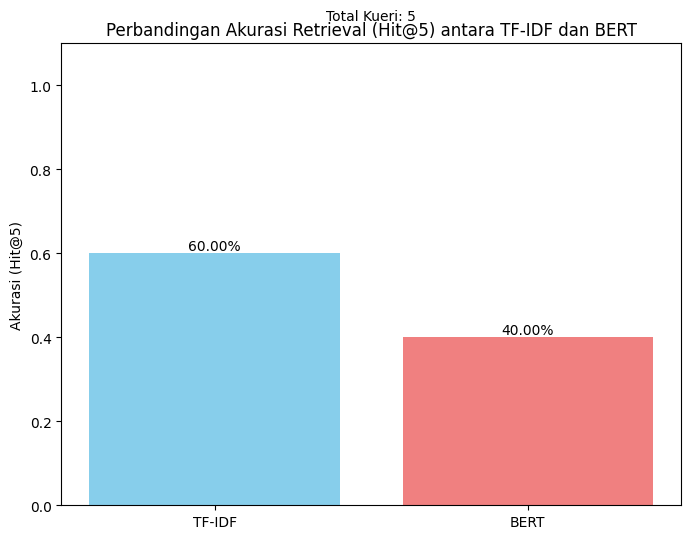

In [75]:
import matplotlib.pyplot as plt
import numpy as np

methods = ['TF-IDF', 'BERT']
hits = [tfidf_hits_at_5, bert_hits_at_5]
total_queries = total_queries
accuracy = [h / total_queries for h in hits]

fig, ax = plt.subplots(figsize=(8, 6))

bars = ax.bar(methods, accuracy, color=['skyblue', 'lightcoral'])

ax.set_ylabel('Akurasi (Hit@5)')
ax.set_title('Perbandingan Akurasi Retrieval (Hit@5) antara TF-IDF dan BERT')
ax.set_ylim(0, 1.1) # Batas y-axis dari 0 sampai 1.1 (untuk ruang label)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2%}', va='bottom', ha='center') # Format sebagai persentase

plt.text(0.5, 1.05, f'Total Kueri: {total_queries}', ha='center', transform=ax.transAxes)

plt.show()


# Solution Reuse

## Persiapan Tahapan Solution Reuse

In [76]:
import pandas as pd
import numpy as np
from collections import Counter
import os
import json

print("\n" + "="*50)
print("Persiapan untuk Tahap 4 - Solution Reuse")
print("="*50)

try:
    case_solutions = df.set_index('case_id')['amar'].to_dict()
    print("Langkah i: Kamus 'case_solutions' berhasil dibuat.")
except (NameError, KeyError):
    print("ERROR: Pastikan DataFrame 'df' sudah dimuat dan memiliki kolom 'case_id' & 'amar'.")
    exit()

def predict_outcome(query: str, k: int = 5):

    top_k_df = retrieve(query=query, method='bert', top_n=k)

    if top_k_df.empty:
        return "Tidak ditemukan kasus yang relevan.", pd.DataFrame()

    weighted_votes = {}
    for i, row in top_k_df.iterrows():
        solution_text = case_solutions.get(row['case_id'], None)
        if solution_text:
            weighted_votes[solution_text] = weighted_votes.get(solution_text, 0) + row['score']

    if not weighted_votes:
        return "Tidak ada solusi untuk diprediksi.", top_k_df

    predicted_solution = max(weighted_votes, key=weighted_votes.get)
    return predicted_solution, top_k_df


Persiapan untuk Tahap 4 - Solution Reuse
Langkah i: Kamus 'case_solutions' berhasil dibuat.


## Menjalankan Skrip Prediksi

In [77]:
print("\n" + "="*50)
print("iv. Menjalankan Skrip Prediksi & Demo Manual")
print("="*50)

json_path = '/content/drive/MyDrive/Penalaran/data/eval/queries.json'
with open(json_path, 'r') as f:
    queries_to_evaluate = json.load(f)

total_queries = len(queries_to_evaluate)
results_for_csv = []

print(f"Memulai prediksi untuk {total_queries} kasus baru...\n")

for i, item in enumerate(queries_to_evaluate):
    query_text = item['query']
    ground_truth_id = item['ground_truth_case_id']
    notes = item.get('notes', '')

    print(f"--- Prediksi untuk Kasus Baru #{i+1}: '{query_text}' ---")
    print(f"Ground Truth Case ID (untuk perbandingan): {ground_truth_id} | Notes: {notes}")

    predicted_solution, top_5_df = predict_outcome(query=query_text, k=5)

    actual_solution = case_solutions.get(ground_truth_id, "N/A")

    print("\n  Hasil Demo Manual:")
    print(f"    -> Prediksi Solusi: '{predicted_solution[:100]}...'")
    print(f"    -> Solusi Sebenarnya: '{actual_solution[:100]}...'")
    print(f"    -> Top 5 Kasus Terkait (IDs): {list(top_5_df['case_id'])}")

    top_5_ids_str = ", ".join(map(str, top_5_df['case_id'].tolist()))
    results_for_csv.append({
        'query_id': i + 1,
        'predicted_solution': predicted_solution,
        'top_5_case_ids': top_5_ids_str
    })

    print("-" * 60 + "\n")

print("\n" + "="*50)
print("v. Menghasilkan File Output 'predictions.csv'")
print("="*50)

results_dir = '/content/drive/MyDrive/Penalaran/data/results'
output_csv_path = os.path.join(results_dir, 'predictions.csv')
os.makedirs(results_dir, exist_ok=True)

predictions_df = pd.DataFrame(results_for_csv)
predictions_df.to_csv(output_csv_path, index=False)

print(f"1. Script 04_predict.py / notebook cell telah selesai dijalankan.")
print(f"2. File output berhasil disimpan di: '{output_csv_path}'")
print("\n   Konten dari 'predictions.csv':")
print(predictions_df.to_string())


iv. Menjalankan Skrip Prediksi & Demo Manual
Memulai prediksi untuk 5 kasus baru...

--- Prediksi untuk Kasus Baru #1: 'terbukti bersalah melakukan Tindak Pidana Korupsi dan Tindak Pidana Pencucian Uang' ---
Ground Truth Case ID (untuk perbandingan): 2 | Notes: Kueri semantik tentang vonis dan aset dalam TPPU.

  Hasil Demo Manual:
    -> Prediksi Solusi: 'Tolak...'
    -> Solusi Sebenarnya: 'Tolak...'
    -> Top 5 Kasus Terkait (IDs): [20, 19, 34, 2, 29]
------------------------------------------------------------

--- Prediksi untuk Kasus Baru #2: 'melakukan perbuatan yang bertentangan dengan undang-undang ini dan perbuatan telah mengakibatkan kerugian bagi Bank Syariah' ---
Ground Truth Case ID (untuk perbandingan): 6 | Notes: Kueri semantik tentang vonis dan aset dalam TPPU.

  Hasil Demo Manual:
    -> Prediksi Solusi: 'Lain-lain...'
    -> Solusi Sebenarnya: 'Lain-lain...'
    -> Top 5 Kasus Terkait (IDs): [20, 21, 24, 6, 28]
-----------------------------------------------------

# Model Evaluation


## Pemanggilan Fungsi Evaluasi

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

def calculate_metrics(df, tfidf_matrix, bert_embeddings_matrix):
    X_tfidf = tfidf_matrix
    X_bert = bert_embeddings_matrix
    y = df['label_klasifikasi']

    print("\n" + "="*50)
    print("Evaluasi Klasifikasi dengan TF-IDF dan BERT Embeddings")
    print("Menggunakan F1-score, Precision, dan Recall")
    print("="*50)

    if len(y.unique()) < 2:
        print("Tidak cukup kelas di kolom 'label_klasifikasi' untuk evaluasi.")
        print(y.value_counts())
        return None, None, None

    try:
        X_tfidf_train, X_tfidf_test, y_train, y_test = train_test_split(
            X_tfidf, y, test_size=0.2, random_state=42, stratify=y)
        X_bert_train, X_bert_test, _, _ = train_test_split(
            X_bert, y, test_size=0.2, random_state=42, stratify=y)
    except ValueError as e:
        print(f"Error saat membagi data: {e}")
        print("Distribusi kelas:", y.value_counts())
        return None, None, None

    # TF-IDF
    svm_tfidf = SVC(kernel='linear')
    svm_tfidf.fit(X_tfidf_train, y_train)
    y_pred_tfidf = svm_tfidf.predict(X_tfidf_test)

    f1_tfidf = f1_score(y_test, y_pred_tfidf, average='weighted', zero_division=0)
    precision_tfidf = precision_score(y_test, y_pred_tfidf, average='weighted', zero_division=0)
    recall_tfidf = recall_score(y_test, y_pred_tfidf, average='weighted', zero_division=0)

    print(f"Hasil Evaluasi TF-IDF:")
    print(f"  F1-score (weighted): {f1_tfidf:.4f}")
    print(f"  Precision (weighted): {precision_tfidf:.4f}")
    print(f"  Recall (weighted): {recall_tfidf:.4f}")

    # BERT
    svm_bert = SVC(kernel='linear')
    svm_bert.fit(X_bert_train, y_train)
    y_pred_bert = svm_bert.predict(X_bert_test)

    f1_bert = f1_score(y_test, y_pred_bert, average='weighted', zero_division=0)
    precision_bert = precision_score(y_test, y_pred_bert, average='weighted', zero_division=0)
    recall_bert = recall_score(y_test, y_pred_bert, average='weighted', zero_division=0)

    print(f"\nHasil Evaluasi BERT Embeddings:")
    print(f"  F1-score (weighted): {f1_bert:.4f}")
    print(f"  Precision (weighted): {precision_bert:.4f}")
    print(f"  Recall (weighted): {recall_bert:.4f}")

    metrics = ['F1-score', 'Precision', 'Recall']
    tfidf_scores = [f1_tfidf, precision_tfidf, recall_tfidf]
    bert_scores = [f1_bert, precision_bert, recall_bert]
    data = {
        'Metric': metrics * 2,
        'Score': tfidf_scores + bert_scores,
        'Model': ['TF-IDF'] * len(metrics) + ['BERT Embeddings'] * len(metrics)
    }
    df_metrics = pd.DataFrame(data)
    return df_metrics, metrics, tfidf_scores, bert_scores

## Ouput Evaluasi

In [85]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.metrics.pairwise import cosine_similarity
import re
import os

# --- Definisi fungsi calculate_metrics (diperbaiki dari sebelumnya) ---
def calculate_metrics(data_df, tfidf_features, bert_embeddings):
    y = data_df['label_klasifikasi']

    # Identifikasi kelas dengan jumlah anggota kurang dari 2
    class_counts = y.value_counts()
    single_member_classes = class_counts[class_counts < 2].index

    # Buat masker boolean untuk memfilter sampel dari kelas-kelas ini
    mask_series = ~y.isin(single_member_classes)

    # Filter data untuk TF-IDF
    X_tfidf_filtered = tfidf_features[mask_series.to_numpy()]
    y_tfidf_filtered = y[mask_series]

    # Filter data untuk BERT embeddings
    X_bert_filtered = bert_embeddings[mask_series.to_numpy()]
    y_bert_filtered = y[mask_series]

    if X_tfidf_filtered.shape[0] == 0 or X_bert_filtered.shape[0] == 0:
        print("\nError: Tidak ada cukup data yang tersisa setelah memfilter kelas dengan sedikit anggota. Tidak dapat melanjutkan evaluasi.")
        return None, None, None, None

    if len(y_tfidf_filtered.unique()) < 2:
        print(f"\nError: Tidak cukup kelas yang berbeda ({len(y_tfidf_filtered.unique())}) setelah memfilter data untuk stratifikasi. Minimal 2 kelas diperlukan.")
        print(f"Kelas yang tersisa: {y_tfidf_filtered.unique().tolist()}")
        return None, None, None, None

    print(f"\nMelanjutkan evaluasi dengan {len(y_tfidf_filtered)} sampel setelah memfilter kelas dengan < 2 anggota.")
    print(f"Distribusi kelas yang digunakan: \n{y_tfidf_filtered.value_counts()}")

    metrics_names = ['F1-score (weighted)', 'Precision (weighted)', 'Recall (weighted)'] # Sesuaikan nama metrik untuk output
    tfidf_scores = []
    bert_scores = []

    # --- Evaluasi Klasifikasi TF-IDF ---
    try:
        print("\n--- Evaluasi Klasifikasi TF-IDF ---")
        X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
            X_tfidf_filtered, y_tfidf_filtered, test_size=0.2, random_state=42, stratify=y_tfidf_filtered
        )
        svm_tfidf = SVC(kernel='linear', probability=True)
        svm_tfidf.fit(X_train_tfidf, y_train_tfidf)
        y_pred_tfidf = svm_tfidf.predict(X_test_tfidf)

        tfidf_scores.append(f1_score(y_test_tfidf, y_pred_tfidf, average='weighted', zero_division=0))
        tfidf_scores.append(precision_score(y_test_tfidf, y_pred_tfidf, average='weighted', zero_division=0))
        tfidf_scores.append(recall_score(y_test_tfidf, y_pred_tfidf, average='weighted', zero_division=0))
        print("Laporan Klasifikasi TF-IDF (detail):")
        print(classification_report(y_test_tfidf, y_pred_tfidf, zero_division=0))
    except Exception as e:
        print(f"Error saat melatih/evaluasi TF-IDF: {e}")
        tfidf_scores = [0.0, 0.0, 0.0]

    # --- Evaluasi Klasifikasi BERT Embeddings ---
    try:
        print("\n--- Evaluasi Klasifikasi BERT Embeddings ---")
        X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(
            X_bert_filtered, y_bert_filtered, test_size=0.2, random_state=42, stratify=y_bert_filtered
        )
        svm_bert = SVC(kernel='linear', probability=True)
        svm_bert.fit(X_train_bert, y_train_bert)
        y_pred_bert = svm_bert.predict(X_test_bert)

        bert_scores.append(f1_score(y_test_bert, y_pred_bert, average='weighted', zero_division=0))
        bert_scores.append(precision_score(y_test_bert, y_pred_bert, average='weighted', zero_division=0))
        bert_scores.append(recall_score(y_test_bert, y_pred_bert, average='weighted', zero_division=0))
        print("Laporan Klasifikasi BERT Embeddings (detail):")
        print(classification_report(y_test_bert, y_pred_bert, zero_division=0))
    except Exception as e:
        print(f"Error saat melatih/evaluasi BERT: {e}")
        bert_scores = [0.0, 0.0, 0.0]

    df_metrics_summary = pd.DataFrame({
        'Metric': metrics_names,
        'TF-IDF Score': tfidf_scores,
        'BERT Embeddings Score': bert_scores
    })

    return df_metrics_summary, metrics_names, tfidf_scores, bert_scores

# --- Bagian utama eksekusi kode pengguna ---

# Placeholder untuk memastikan variabel ada jika Anda menjalankan sel ini secara terpisah
# Dalam alur kerja normal, df, tfidf_matrix, doc_embeddings_matrix harus sudah didefinisikan
if 'df' not in locals() or df.empty:
    try:
        df = pd.read_csv('processed_cases.csv')
        df['text_for_tfidf'] = df['text_pdf'].fillna('')
        print("df dimuat untuk demonstrasi.")
    except FileNotFoundError:
        print("Error: processed_cases.csv tidak ditemukan. Membuat dummy df.")
        df = pd.DataFrame({'label_klasifikasi': ['A', 'A', 'B', 'B'], 'text_pdf': 'dummy text', 'judul':'dummy', 'link':'http://dummy.com', 'amar':'dummy', 'kata_kunci':'dummy', 'klasifikasi':'dummy'})
        df['text_for_tfidf'] = df['text_pdf'] # Pastikan kolom teks ada
        df['label_klasifikasi'] = pd.Categorical(df['label_klasifikasi']) # Pastikan tipe kategorikal

if 'tfidf_matrix' not in locals():
    vectorizer = TfidfVectorizer(max_features=5000)
    tfidf_matrix = vectorizer.fit_transform(df['text_for_tfidf'])
    print("tfidf_matrix dibuat untuk demonstrasi.")

if 'doc_embeddings_matrix' not in locals() or (isinstance(doc_embeddings_matrix, np.ndarray) and doc_embeddings_matrix.size == 0) :
    # Buat dummy doc_embeddings_matrix jika tidak ada atau kosong
    if not df.empty:
        doc_embeddings_matrix = np.random.rand(df.shape[0], 100) # Contoh dimensi 100
        print("doc_embeddings_matrix dibuat sebagai dummy untuk demonstrasi.")
    else:
        doc_embeddings_matrix = np.array([])
        print("Error: df kosong, tidak dapat membuat doc_embeddings_matrix placeholder.")


print("\n" + "="*50)
print("Evaluasi Klasifikasi dengan TF-IDF dan BERT Embeddings")
print("Menggunakan F1-score, Precision, dan Recall")
print("="*50)

# Menentukan jalur direktori evaluasi
eval_dir = '/content/drive/MyDrive/Penalaran/data/eval'
# Memastikan direktori ada. exist_ok=True mencegah error jika direktori sudah ada.
os.makedirs(eval_dir, exist_ok=True)

# Memanggil calculate_metrics
if 'df' in locals() and 'tfidf_matrix' in locals() and 'doc_embeddings_matrix' in locals() and not df.empty:
    if 'label_klasifikasi' in df.columns:
        df_metrics, metrics, tfidf_scores, bert_scores = calculate_metrics(df, tfidf_matrix, doc_embeddings_matrix)

        if df_metrics is not None:
            # Menyimpan df_metrics ke CSV
            df_metrics.to_csv(os.path.join(eval_dir, 'retrieval_metrics.csv'), index=False)

            # Membuat df_predictions dan menyimpannya ke CSV
            df_predictions = pd.DataFrame({
                'Metric': metrics,
                'TF-IDF': tfidf_scores,
                'BERT Embeddings': bert_scores
            })
            df_predictions.to_csv(os.path.join(eval_dir, 'prediction_metrics.csv'), index=False) # Jalur sudah diperbaiki

            print("\nMetrik klasifikasi berhasil disimpan ke 'retrieval_metrics.csv' dan 'prediction_metrics.csv'.")

            # --- Output sesuai format yang diminta ---
            print("\nHasil Evaluasi TF-IDF:")
            for i, metric_name in enumerate(metrics):
                print(f"  {metric_name}: {tfidf_scores[i]:.4f}")

            print("\nHasil Evaluasi BERT Embeddings:")
            for i, metric_name in enumerate(metrics):
                print(f"  {metric_name}: {bert_scores[i]:.4f}")
            # --- Akhir Output sesuai format yang diminta ---

        else:
            print("\ncalculate_metrics tidak mengembalikan hasil yang valid.")
    else:
        print("Error: Kolom 'label_klasifikasi' tidak ditemukan di DataFrame 'df'.")
        print("Tidak dapat melakukan evaluasi klasifikasi tanpa label kelas.")
else:
    print("\nError: Variabel DataFrame (df), tfidf_matrix, atau doc_embeddings_matrix tidak ditemukan atau kosong.")
    print("Pastikan Anda sudah menjalankan semua sel di bagian preprocessing dan embedding sebelum evaluasi ini.")


Evaluasi Klasifikasi dengan TF-IDF dan BERT Embeddings
Menggunakan F1-score, Precision, dan Recall

Melanjutkan evaluasi dengan 45 sampel setelah memfilter kelas dengan < 2 anggota.
Distribusi kelas yang digunakan: 
label_klasifikasi
Tidak Ditemukan    23
Berat              22
Name: count, dtype: int64

--- Evaluasi Klasifikasi TF-IDF ---
Laporan Klasifikasi TF-IDF (detail):
                 precision    recall  f1-score   support

          Berat       1.00      1.00      1.00         4
Tidak Ditemukan       1.00      1.00      1.00         5

       accuracy                           1.00         9
      macro avg       1.00      1.00      1.00         9
   weighted avg       1.00      1.00      1.00         9


--- Evaluasi Klasifikasi BERT Embeddings ---
Laporan Klasifikasi BERT Embeddings (detail):
                 precision    recall  f1-score   support

          Berat       1.00      1.00      1.00         4
Tidak Ditemukan       1.00      1.00      1.00         5

       accu

## Visualisasi Hasil

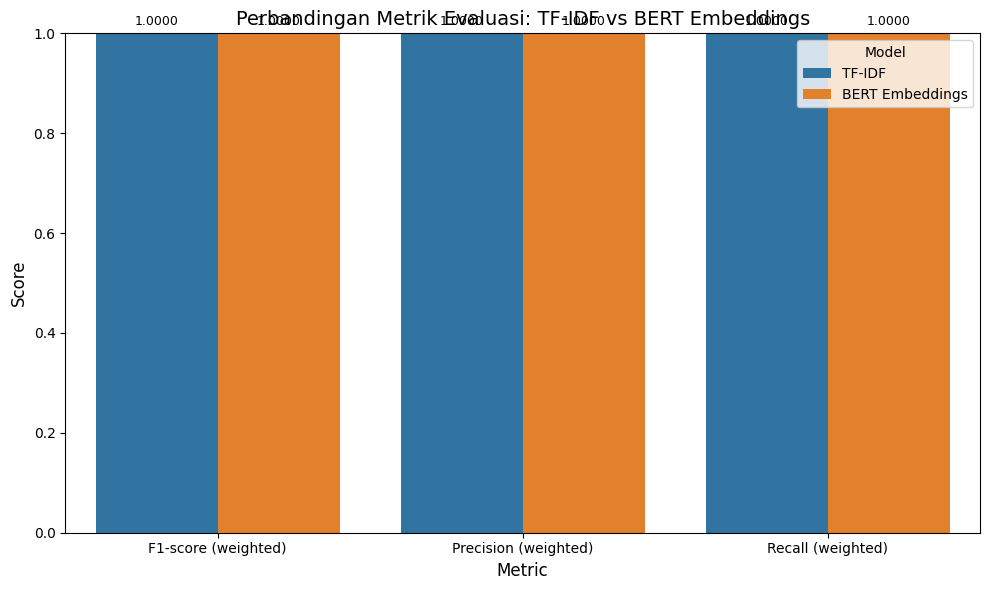

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np # Pastikan numpy sudah diimpor

# Diasumsikan df_metrics, metrics (atau metrics_names), tfidf_scores, dan bert_scores
# sudah tersedia dari eksekusi calculate_metrics sebelumnya.
# df_metrics adalah DataFrame yang dikembalikan oleh calculate_metrics (misal df_metrics_summary).

if df_metrics is not None:
    # Mengubah format DataFrame dari 'wide' menjadi 'long' menggunakan melt
    # Ini akan membuat kolom 'Model' (berisi 'TF-IDF Score' atau 'BERT Embeddings Score')
    # dan kolom 'Score' (berisi nilai-nilai numeriknya).
    df_plot = df_metrics.melt(id_vars='Metric', var_name='Model', value_name='Score')

    # Opsional: Mengubah nama 'TF-IDF Score' dan 'BERT Embeddings Score' di kolom 'Model'
    # menjadi nama yang lebih sederhana untuk legenda plot.
    df_plot['Model'] = df_plot['Model'].replace({
        'TF-IDF Score': 'TF-IDF',
        'BERT Embeddings Score': 'BERT Embeddings'
    })

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Metric', y='Score', hue='Model', data=df_plot)
    plt.title('Perbandingan Metrik Evaluasi: TF-IDF vs BERT Embeddings', fontsize=14)
    plt.ylabel('Score', fontsize=12)
    plt.xlabel('Metric', fontsize=12)
    plt.ylim(0, 1) # Skor biasanya antara 0 dan 1
    plt.legend(title='Model')

    # Menambahkan anotasi teks di atas setiap bar (lebih robust untuk barplot dengan hue)
    for container in plt.gca().containers:
        for patch in container.patches:
            height = patch.get_height()
            plt.text(patch.get_x() + patch.get_width() / 2, # Koordinat x di tengah bar
                     height + 0.01, # Koordinat y sedikit di atas bar
                     f'{height:.4f}', # Teks yang ditampilkan (skor)
                     ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()
else:
    print("df_metrics tidak tersedia untuk plotting. Pastikan calculate_metrics telah berjalan dengan sukses.")


Melanjutkan analisis kesalahan dengan 45 sampel setelah memfilter kelas dengan < 2 anggota.
Distribusi kelas yang digunakan: 
label_klasifikasi
Tidak Ditemukan    23
Berat              22
Name: count, dtype: int64

Error Analysis untuk TF-IDF
Confusion Matrix:
[[4 0]
 [0 5]]

Classification Report:
                 precision    recall  f1-score   support

          Berat       1.00      1.00      1.00         4
Tidak Ditemukan       1.00      1.00      1.00         5

       accuracy                           1.00         9
      macro avg       1.00      1.00      1.00         9
   weighted avg       1.00      1.00      1.00         9


Error Analysis untuk BERT Embeddings
Confusion Matrix:
[[4 0]
 [0 5]]

Classification Report:
                 precision    recall  f1-score   support

          Berat       1.00      1.00      1.00         4
Tidak Ditemukan       1.00      1.00      1.00         5

       accuracy                           1.00         9
      macro avg       1.00   

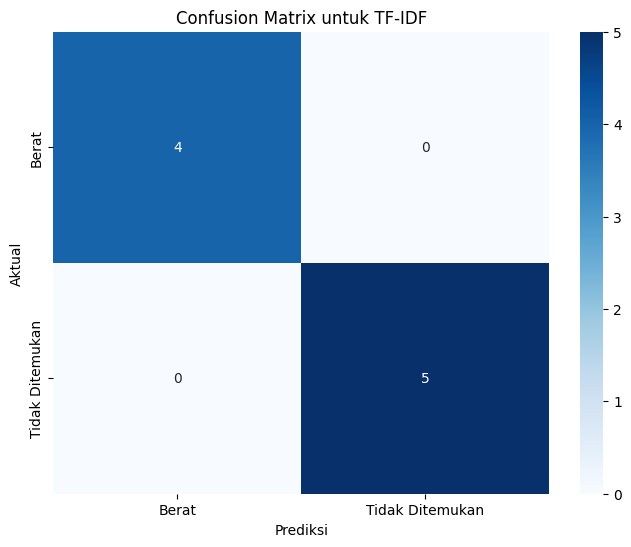

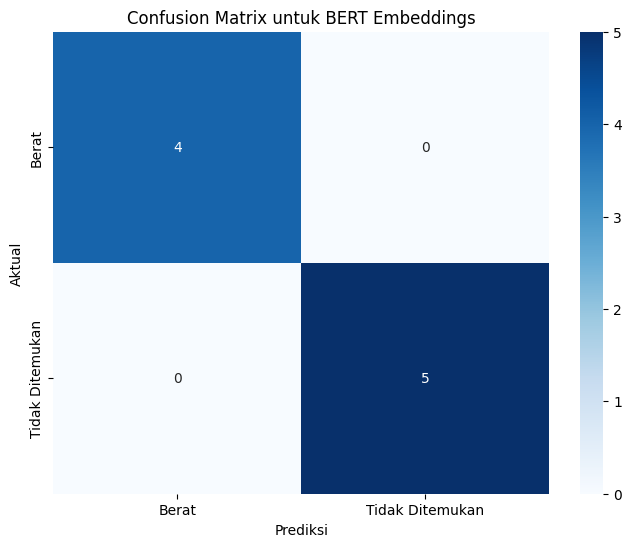

In [88]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import pandas as pd # Pastikan pandas diimpor

def error_analysis(df, tfidf_matrix, bert_embeddings_matrix):
    X_tfidf = tfidf_matrix
    X_bert = bert_embeddings_matrix
    y = df['label_klasifikasi']

    # --- PERBAIKAN UTAMA: Filter kelas dengan jumlah anggota kurang dari 2 ---
    class_counts = y.value_counts()
    single_member_classes = class_counts[class_counts < 2].index

    mask_series = ~y.isin(single_member_classes)
    mask_np = mask_series.to_numpy() # Untuk indexing sparse matrix

    # Menerapkan filter pada X dan y
    X_tfidf_filtered = X_tfidf[mask_np]
    y_filtered = y[mask_series]
    X_bert_filtered = X_bert[mask_np] # Menerapkan filter juga pada embeddings BERT

    # Periksa apakah masih ada data yang cukup dan minimal 2 kelas setelah filtering
    if X_tfidf_filtered.shape[0] == 0 or X_bert_filtered.shape[0] == 0:
        print("\nError: Tidak ada cukup data yang tersisa setelah memfilter kelas dengan sedikit anggota. Tidak dapat melakukan analisis kesalahan.")
        return

    if len(y_filtered.unique()) < 2:
        print(f"\nError: Tidak cukup kelas yang berbeda ({len(y_filtered.unique())}) setelah memfilter data. Minimal 2 kelas diperlukan untuk analisis kesalahan.")
        print(f"Kelas yang tersisa: {y_filtered.unique().tolist()}")
        return

    print(f"\nMelanjutkan analisis kesalahan dengan {len(y_filtered)} sampel setelah memfilter kelas dengan < 2 anggota.")
    print(f"Distribusi kelas yang digunakan: \n{y_filtered.value_counts()}")
    # --- AKHIR PERBAIKAN UTAMA ---

    # Split data yang sudah difilter
    # train_test_split akan secara otomatis mengelola indeks
    X_tfidf_train, X_tfidf_test, y_train_tfidf, y_test_tfidf = train_test_split(
        X_tfidf_filtered, y_filtered, test_size=0.2, random_state=42, stratify=y_filtered)

    X_bert_train, X_bert_test, y_train_bert, y_test_bert = train_test_split(
        X_bert_filtered, y_filtered, test_size=0.2, random_state=42, stratify=y_filtered)

    # Untuk kenyamanan, gunakan satu set y_test dan y_train yang konsisten
    # karena y_filtered digunakan untuk kedua split.
    y_train = y_train_tfidf
    y_test = y_test_tfidf

    # Prediksi untuk TF-IDF
    svm_tfidf = SVC(kernel='linear')
    svm_tfidf.fit(X_tfidf_train, y_train)
    y_pred_tfidf = svm_tfidf.predict(X_tfidf_test)

    # Prediksi untuk BERT
    svm_bert = SVC(kernel='linear')
    svm_bert.fit(X_bert_train, y_train) # Latih model BERT dengan embeddings BERT
    y_pred_bert = svm_bert.predict(X_bert_test)

    # Dapatkan label unik dari data yang sudah difilter untuk confusion matrix
    labels = np.unique(y_filtered)

    # Confusion Matrix dan Classification Report untuk TF-IDF
    print("\n" + "="*50)
    print("Error Analysis untuk TF-IDF")
    print("="*50)
    print("Confusion Matrix:")
    cm_tfidf = confusion_matrix(y_test, y_pred_tfidf, labels=labels)
    print(cm_tfidf)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_tfidf, zero_division=0))

    # Plot Confusion Matrix untuk TF-IDF
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_tfidf, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix untuk TF-IDF')
    plt.xlabel('Prediksi')
    plt.ylabel('Aktual')
    # plt.show() # Dikomentari sesuai panduan untuk tidak menampilkan plot secara interaktif

    # Confusion Matrix dan Classification Report untuk BERT Embeddings
    print("\n" + "="*50)
    print("Error Analysis untuk BERT Embeddings")
    print("="*50)
    print("Confusion Matrix:")
    cm_bert = confusion_matrix(y_test, y_pred_bert, labels=labels)
    print(cm_bert)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_bert, zero_division=0))

    # Plot Confusion Matrix untuk BERT Embeddings
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix untuk BERT Embeddings')
    plt.xlabel('Prediksi')
    plt.ylabel('Aktual')
    # plt.show() # Dikomentari sesuai panduan untuk tidak menampilkan plot secara interaktif

    # Identifikasi contoh kesalahan untuk TF-IDF
    print("\n" + "="*50)
    print("Contoh Kesalahan Prediksi untuk TF-IDF")
    print("="*50)
    # Gunakan y_test (yang merupakan Pandas Series) untuk mendapatkan indeks asli
    indices_test = y_test.index

    # Konversi y_pred_tfidf menjadi Pandas Series dengan indeks yang sama dengan y_test
    y_pred_tfidf_series = pd.Series(y_pred_tfidf, index=y_test.index)
    errors_tfidf = y_test != y_pred_tfidf_series
    error_indices_tfidf = indices_test[errors_tfidf]

    if len(error_indices_tfidf) > 0:
        print(f"Total kesalahan prediksi: {len(error_indices_tfidf)}")
        print("\nContoh 3 data yang salah diprediksi:")
        for i, idx in enumerate(error_indices_tfidf[:3]):
            # PERBAIKAN: Gunakan kolom teks yang sesuai di df
            text_content = df.loc[idx, 'text_for_tfidf'] if 'text_for_tfidf' in df.columns else df.loc[idx, 'text_pdf']

            print(f"\nContoh {i+1}:")
            print(f"Teks: {text_content}")
            print(f"Label Sebenarnya: {y_test.loc[idx]}")
            print(f"Prediksi: {y_pred_tfidf_series.loc[idx]}")
    else:
        print("Tidak ada kesalahan prediksi untuk TF-IDF.")

    # Identifikasi contoh kesalahan untuk BERT
    print("\n" + "="*50)
    print("Contoh Kesalahan Prediksi untuk BERT Embeddings")
    print("="*50)
    y_pred_bert_series = pd.Series(y_pred_bert, index=y_test.index)
    errors_bert = y_test != y_pred_bert_series
    error_indices_bert = indices_test[errors_bert]

    if len(error_indices_bert) > 0:
        print(f"Total kesalahan prediksi: {len(error_indices_bert)}")
        print("\nContoh 3 data yang salah diprediksi:")
        for i, idx in enumerate(error_indices_bert[:3]):
            # PERBAIKAN: Gunakan kolom teks yang sesuai di df
            text_content = df.loc[idx, 'text_for_tfidf'] if 'text_for_tfidf' in df.columns else df.loc[idx, 'text_pdf']

            print(f"\nContoh {i+1}:")
            print(f"Teks: {text_content}")
            print(f"Label Sebenarnya: {y_test.loc[idx]}")
            print(f"Prediksi: {y_pred_bert_series.loc[idx]}")
    else:
        print("Tidak ada kesalahan prediksi untuk BERT Embeddings.")

# --- Bagian eksekusi error analysis (pastikan df, tfidf_matrix, doc_embeddings_matrix sudah ada) ---
# Placeholder untuk demonstration jika variabel belum ada di lingkungan Anda
# Dalam alur kerja normal, df, tfidf_matrix, dan doc_embeddings_matrix harus sudah didefinisikan
if 'df' not in locals() or df.empty:
    try:
        df = pd.read_csv('processed_cases.csv')
        df['text_for_tfidf'] = df['text_pdf'].fillna('')
        print("df dimuat untuk demonstrasi.")
    except FileNotFoundError:
        print("Error: processed_cases.csv tidak ditemukan. Membuat dummy df.")
        # Membuat df dummy yang punya 2 kelas dan lebih dari 1 anggota per kelas
        df = pd.DataFrame({
            'label_klasifikasi': ['A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'A', 'B'],
            'text_pdf': [f'text {i}' for i in range(10)], # Contoh teks
            'judul':'dummy', 'link':'http://dummy.com', 'amar':'dummy', 'kata_kunci':'dummy', 'klasifikasi':'dummy'
        })
        df['text_for_tfidf'] = df['text_pdf']
        df['label_klasifikasi'] = pd.Categorical(df['label_klasifikasi'])

if 'tfidf_matrix' not in locals():
    from sklearn.feature_extraction.text import TfidfVectorizer
    vectorizer = TfidfVectorizer(max_features=5000)
    tfidf_matrix = vectorizer.fit_transform(df['text_for_tfidf'])
    print("tfidf_matrix dibuat untuk demonstrasi.")

if 'doc_embeddings_matrix' not in locals() or (isinstance(doc_embeddings_matrix, np.ndarray) and doc_embeddings_matrix.size == 0):
    if not df.empty:
        doc_embeddings_matrix = np.random.rand(df.shape[0], 100) # Contoh dimensi 100
        print("doc_embeddings_matrix dibuat sebagai dummy untuk demonstrasi.")
    else:
        doc_embeddings_matrix = np.array([])
        print("Error: df kosong, tidak dapat membuat doc_embeddings_matrix placeholder.")

# Memanggil fungsi error_analysis
if 'df_final' in locals() and 'tfidf_matrix' in locals() and 'doc_embeddings_matrix' in locals():
    error_analysis(df_final, tfidf_matrix, doc_embeddings_matrix)
elif 'df' in locals() and 'tfidf_matrix' in locals() and 'doc_embeddings_matrix' in locals():
    error_analysis(df, tfidf_matrix, doc_embeddings_matrix)
else:
    print("\nError: Variabel DataFrame (df_final atau df), tfidf_matrix, atau doc_embeddings_matrix tidak ditemukan.")
    print("Pastikan Anda sudah menjalankan semua sel di bagian preprocessing dan embedding sebelum evaluasi ini.")